<a href="https://colab.research.google.com/github/engineerjkk/Supervised-Contrastive-Learning/blob/main/examples/vision/ipynb/supervised-contrastive-learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Contrastive Learning

**Author:** [Khalid Salama](https://www.linkedin.com/in/khalid-salama-24403144/)<br>
**Date created:** 2020/11/30<br>
**Last modified:** 2020/11/30<br>
**Description:** Using supervised contrastive learning for image classification.

## Introduction

[Supervised Contrastive Learning](https://arxiv.org/abs/2004.11362)
(Prannay Khosla et al.) is a training methodology that outperforms
supervised training with crossentropy on classification tasks.

Essentially, training an image classification model with Supervised Contrastive
Learning is performed in two phases:

1. Training an encoder to learn to produce vector representations of input images such
that representations of images in the same class will be more similar compared to
representations of images in different classes.
2. Training a classifier on top of the frozen encoder.

Note that this example requires [TensorFlow Addons](https://www.tensorflow.org/addons), which you can install using the following command:

```python
pip install tensorflow-addons
```

## Setup

In [1]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.0 MB/s 


In [2]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

## Prepare the data

CIFAR10 데이터셋을 사용한다.  
클래스 수는 10개이며, 32 by 32 pixels의 3채널을 갖는 컬러이미지 데이터셋이다. 

In [3]:
num_classes = 10
input_shape = (32, 32, 3)

# Load the train and test data splits
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Display shapes of train and test datasets
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


170508288/170498071 [==============================] - 2s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


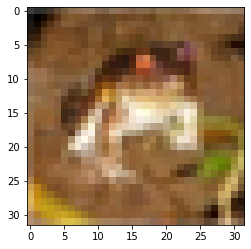

In [4]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0])

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.RandomFlip("horizontal"),#랜덤으로 가로로 뒤집어줌.
        layers.RandomRotation(0.02),#랜덤으로 0.02만큼 Rotation을 수행해줌.
        layers.RandomWidth(0.2),#width를 0.2만큼 늘려준다.
        layers.RandomHeight(0.2),#Height를 0.2만큼 늘려준다. 
    ]
)

# Setting the state of the normalization layer.
data_augmentation.layers[0].adapt(x_train)

## Build the encoder model

The encoder model takes the image as input and turns it into a 2048-dimensional
feature vector.

In [6]:

def create_encoder():
    #ResNet 내부 파라미터를 설정한다. include_top을 False를 함으로써 FC Layer를 안줘서 Feature Task만 사용한다.
    resnet = keras.applications.ResNet50V2(
        include_top=False, weights=None, input_shape=input_shape, pooling="avg"
    )
    

    inputs = keras.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    outputs = resnet(augmented)#augmented된 이미지를 넣어준다. 
    model = keras.Model(inputs=inputs, outputs=outputs, name="cifar10-encoder")
    return model


encoder = create_encoder()#create_encoder를 통해서 모델을 만든다. 
encoder.summary()#아래 encoder에 대한 summary가 출력된다.

learning_rate = 0.001
batch_size = 265
hidden_units = 512
projection_units = 128
num_epochs = 50
dropout_rate = 0.5
temperature = 0.05
#32 by 32 사이즈의 3채널 이미지가 input으로 들어오게되며, 최종 출력되는 차원은 2048 dimension의 feature vector가 출력된다.
#Fully Connected Layer가 없으므로 2048차원의 feature vector만 사용되는 것이다.

Model: "cifar10-encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 32, 32, 3)         7         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
Total params: 23,564,807
Trainable params: 23,519,360
Non-trainable params: 45,447
_________________________________________________________________


## Build the classification model

The classification model adds a fully-connected layer on top of the encoder,
plus a softmax layer with the target classes.

이제 Stage2의 Classification model을 만들어야한다. 

In [7]:

def create_classifier(encoder, trainable=True):

    for layer in encoder.layers:
        layer.trainable = trainable

    inputs = keras.Input(shape=input_shape)
    print("input_shape :",input_shape)
    features = encoder(inputs)#input shape 32x32x3 사이즈를 넣어준다.
    features = layers.Dropout(dropout_rate)(features)#드롭아웃과함께 이전 레이어의 아웃풋을 넣어준다.
    features = layers.Dense(hidden_units, activation="relu")(features)#128차원으로 만들어주며, activation function은 relu를 사용한다.
    features = layers.Dropout(dropout_rate)(features)#다시한번 더 dropout을 사용한다. 
    outputs = layers.Dense(num_classes, activation="softmax")(features)#class 개수만큼의 차원으로 만들어준다. activation function은 softmax를 사용한다.

    model = keras.Model(inputs=inputs, outputs=outputs, name="cifar10-classifier")#이렇게 classifier 모델을 완성해준다.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),#optimizer는 Adan을 사용했으며, learning rate는 0.001을 사용한다.
        loss=keras.losses.SparseCategoricalCrossentropy(),#사용하는 cross entropy로는 sparseCetegorialCrossentropy를 사용한다. 내부적으로 알아서 one hot vector로 만들어주는 cross entropy이다. 
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )
    return model


## Experiment 1: Train the baseline classification model

In this experiment, a baseline classifier is trained as usual, i.e., the
encoder and the classifier parts are trained together as a single model
to minimize the crossentropy loss.

encoder와 classifier 부분이 함께 하나의 모델에서 train되며, crossentropy loss를 minimize한다. 

In [8]:
encoder = create_encoder()#encoder 모델을 생성해주며,
classifier = create_classifier(encoder)#인코더 모델의 output을 classifier에 넣어준다. 
classifier.summary()

history = classifier.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=num_epochs)

accuracy = classifier.evaluate(x_test, y_test)[1]
print(f"Test accuracy: {round(accuracy * 100, 2)}%")


Model: "cifar10-classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 cifar10-encoder (Functional  (None, 2048)             23564807  
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                

## Experiment 2: Use supervised contrastive learning

In this experiment, the model is trained in two phases. In the first phase,
the encoder is pretrained to optimize the supervised contrastive loss,
described in [Prannay Khosla et al.](https://arxiv.org/abs/2004.11362).

In the second phase, the classifier is trained using the trained encoder with
its weights freezed; only the weights of fully-connected layers with the
softmax are optimized.

### 1. Supervised contrastive learning loss function
Loss Function을 제안한다.

In [9]:

class SupervisedContrastiveLoss(keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super(SupervisedContrastiveLoss, self).__init__(name=name)
        self.temperature = temperature #similarity 값을 scaling해주는 tau인 temperature 값을 1로 설정한다. 

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)##veature vector를 Normalization 시켜준뒤에,
        # Compute logits 
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)#자기 자신과 autmented된 positive 또는 negative image를 곱해준다.
            ),
            self.temperature,#그리고 scaling을 위해 temperature constant로 나누어준다. 
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits) #tfa.losses.npairs_loss API를 사용해서 실제 레이블된 ground true 값과 예측된 값의 pair loss를 계산한다. 


def add_projection_head(encoder):#인코더 이후에 projection head를 추가한다. MLP이다.
    inputs = keras.Input(shape=input_shape)#3채널 32 by 32의 input shape을 input으로 넣어준뒤,
    features = encoder(inputs)#인코더에 넣어준다.
    outputs = layers.Dense(projection_units, activation="relu")(features)#그리고 DenseLayer로 128차원으로 만들어주고, ReLU Activation Function을 사용한다. 
    model = keras.Model(#이렇게 input 3채널 32 by 32 사이즈 input, 128차원의 output으로 나오는 모델을 생성하여준다.
        inputs=inputs, outputs=outputs, name="cifar-encoder_with_projection-head"
    )
    return model


### 2. Pretrain the encoder
- 먼저 pretraining과정이 필요하다.

In [10]:
encoder = create_encoder() #인코더를 생성해준다. 

encoder_with_projection_head = add_projection_head(encoder)#그리고 인코더에 projection head를 추가해준다. 
encoder_with_projection_head.compile(
    optimizer=keras.optimizers.Adam(learning_rate),#optimizer로는 Adam optimizer를 사용하며,
    loss=SupervisedContrastiveLoss(temperature),#Loss Function으로는 SupCon LossFunction을 사용하며, 파라미터인 temperature constant 1을 줍니다. 
)

encoder_with_projection_head.summary()#Summary를 해주고,

history = encoder_with_projection_head.fit(#x에 트레이닝셋, y에 y 트레이닝셋, batch_size는 265를 주었으며, epochs는 50을 주어 학습을 진행했습니다. 
    x=x_train, y=y_train, batch_size=batch_size, epochs=num_epochs
)

Model: "cifar-encoder_with_projection-head"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 cifar10-encoder (Functional  (None, 2048)             23564807  
 )                                                               
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
Total params: 23,827,079
Trainable params: 23,781,632
Non-trainable params: 45,447
_________________________________________________________________
Epoch 1/50
189/189 [==============================] - 29s 125ms/step - loss: 5.3751
Epoch 2/50
189/189 [==============================] - 24s 130ms/step - loss: 5.1291
Epoch 3/50
189/189 [=========================

### 3. Train the classifier with the frozen encoder
- encoder를 frozen시킨 값을 classifier에 넣어줘서 classifier를 생성한다. 

In [11]:
classifier = create_classifier(encoder, trainable=False)#

history = classifier.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=num_epochs)
#classifier 모델의 fit에 x train과 y train 그리고 batch size는 256을 주었으며 epoch는 50회를 주었다. 
accuracy = classifier.evaluate(x_test, y_test)[1]
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

Epoch 1/50
189/189 [==============================] - 10s 37ms/step - loss: 0.3583 - sparse_categorical_accuracy: 0.9031
Epoch 2/50
189/189 [==============================] - 7s 36ms/step - loss: 0.2975 - sparse_categorical_accuracy: 0.9111
Epoch 3/50
189/189 [==============================] - 7s 36ms/step - loss: 0.2871 - sparse_categorical_accuracy: 0.9115
Epoch 4/50
189/189 [==============================] - 7s 36ms/step - loss: 0.2809 - sparse_categorical_accuracy: 0.9114
Epoch 5/50
189/189 [==============================] - 7s 37ms/step - loss: 0.2878 - sparse_categorical_accuracy: 0.9120
Epoch 6/50
189/189 [==============================] - 7s 38ms/step - loss: 0.2797 - sparse_categorical_accuracy: 0.9129
Epoch 7/50
189/189 [==============================] - 7s 36ms/step - loss: 0.2791 - sparse_categorical_accuracy: 0.9128
Epoch 8/50
189/189 [==============================] - 7s 37ms/step - loss: 0.2761 - sparse_categorical_accuracy: 0.9138
Epoch 9/50
189/189 [===================

We get to an improved test accuracy.

## Conclusion

As shown in the experiments, using the supervised contrastive learning technique
outperformed the conventional technique in terms of the test accuracy. Note that
the same training budget (i.e., number of epochs) was given to each technique.
Supervised contrastive learning pays off when the encoder involves a complex
architecture, like ResNet, and multi-class problems with many labels.
In addition, large batch sizes and multi-layer projection heads
improve its effectiveness. See the [Supervised Contrastive Learning](https://arxiv.org/abs/2004.11362)
paper for more details.

You can use the trained model hosted on [Hugging Face Hub](https://huggingface.co/keras-io/supervised-contrastive-learning-cifar10) and try the demo on [Hugging Face Spaces](https://huggingface.co/spaces/keras-io/supervised-contrastive-learning).